# Model Comparison and Selection

We assume that all the necessary packages are already installed as explained in the README.

# Question Generation (QG) Model Comparison

In [73]:
import json
import datasets
from cliffs_delta import cliffs_delta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import evaluate
from scipy.stats import shapiro, kruskal, spearmanr

In [74]:
def load_question_model_data_from_file(prefix, metric):
    """
    Load the question model data from the file.
    
    :param prefix: the prefix of the file
    :param metric: the metric to load
    :return: the data
    """
    filename = f"./question_models_results/{prefix}_score_{metric}.json"
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data['scores']

def load_question_model_data(model_name, score_metrics):
    """
    Load the question model data from the file.
        
    :param model_name: the name of the model
    :param score_metrics: the metrics to load
    """
    first_metric_data = load_question_model_data_from_file(model_name, score_metrics[0])
    data = pd.DataFrame(first_metric_data, columns=[score_metrics[0]])

    for metric in score_metrics[1:]:
        next_metric_data = load_question_model_data_from_file(model_name, metric)
        data[metric] = next_metric_data
    return data

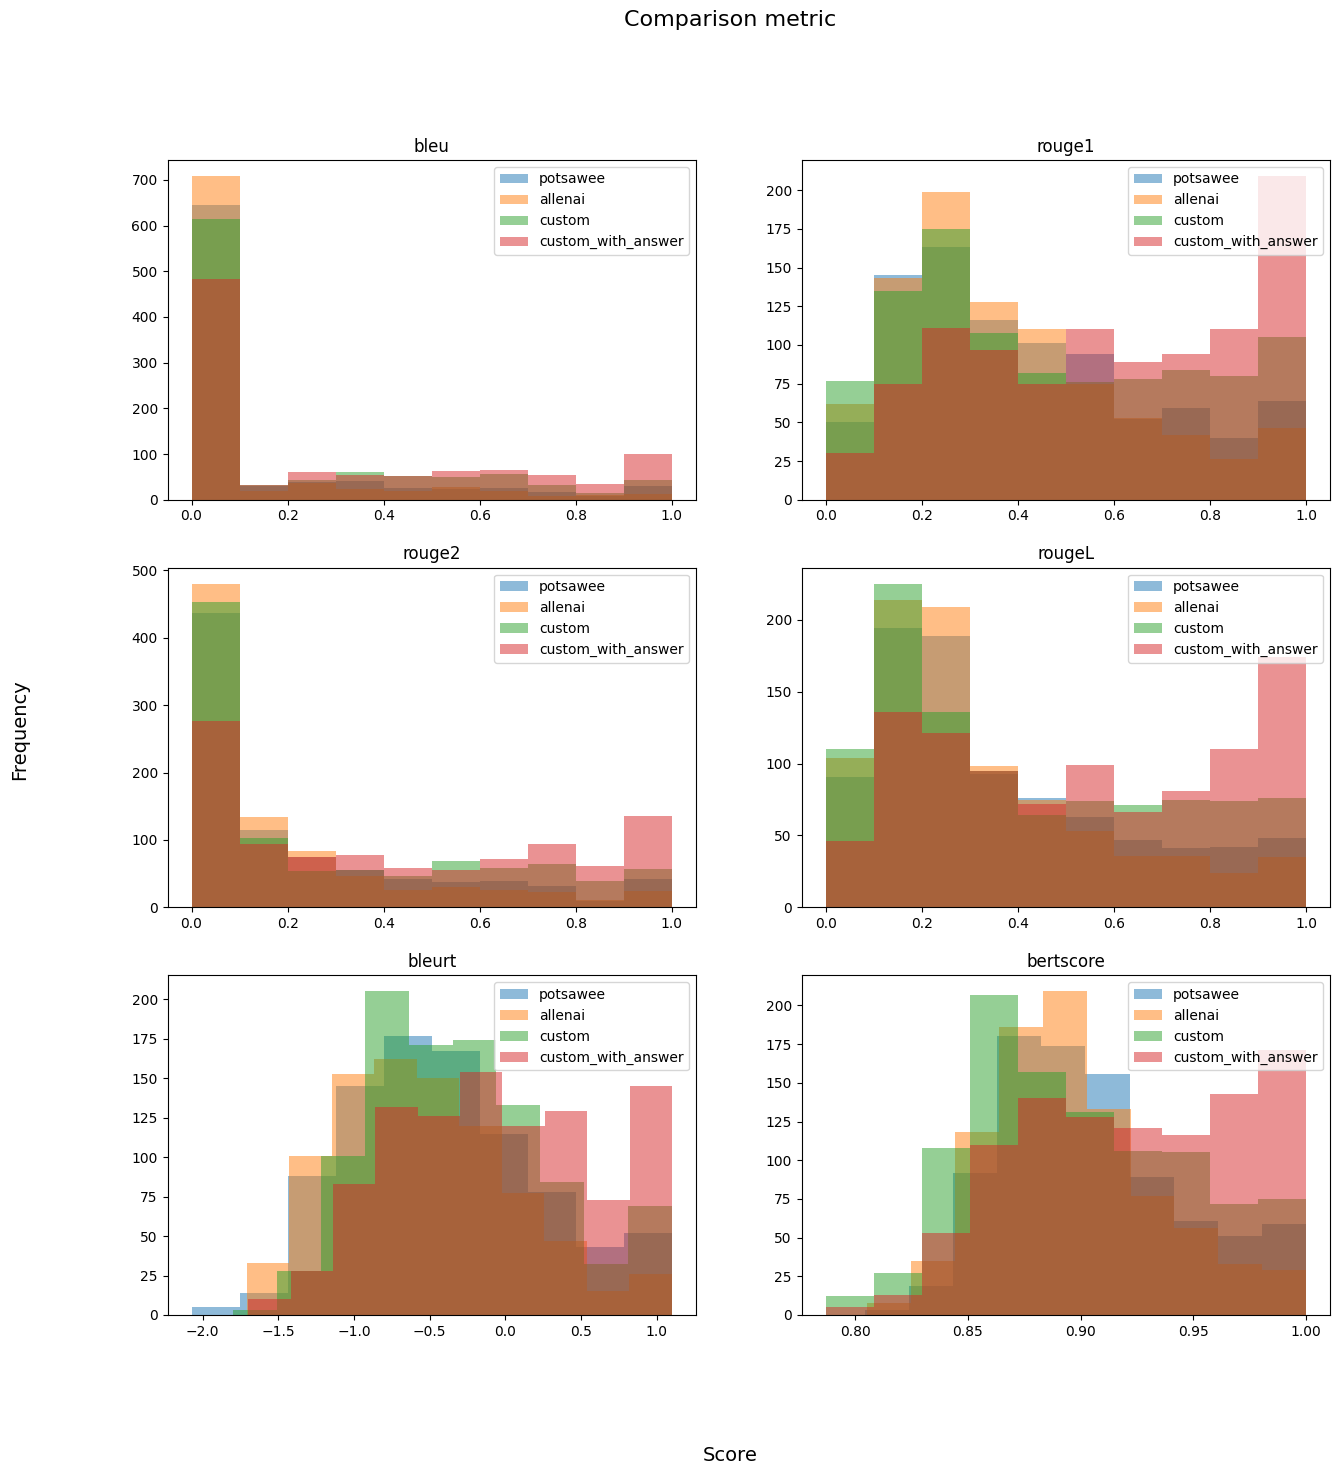

In [75]:
score_metrics = ['bleu', 'rouge1', 'rouge2', 'rougeL', 'bleurt', 'bertscore']
potsawee_question = load_question_model_data('potsawee', score_metrics)
allenai_question = load_question_model_data('allenai', score_metrics)
custom_question = load_question_model_data('custom', score_metrics)
custom_with_answer_question = load_question_model_data('custom_with_answer', score_metrics)

def plot_score_metrics(data1, data2, data3, data4, title, metrics):
    """
    Plot the score metrics as histograms.
    
    :param data1: the first data
    :param data2: the second data
    :param data3: the third data
    :param data4: the fourth data
    :param title: the title of the plot
    :param metrics: the metrics to plot
    """
    fig, ax = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)
    fig.supxlabel('Score', fontsize=14)
    fig.supylabel('Frequency', fontsize=14)
    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax[row, col].hist(data1[metric], label='potsawee', alpha=0.5)
        ax[row, col].hist(data2[metric], label='allenai', alpha=0.5)
        ax[row, col].hist(data3[metric], label='custom', alpha=0.5)
        ax[row, col].hist(data4[metric], label='custom_with_answer', alpha=0.5)
        ax[row, col].set_title(metric)
        ax[row, col].legend()
plot_score_metrics(potsawee_question.dropna(), allenai_question.dropna(), custom_question.dropna(), custom_with_answer_question.dropna(), 'Comparison metric', score_metrics)

# Statistical Analysis of QG models
Cliff's delta is an effect size statistic appropriate in cases where a Wilcoxon-Mann-Whitney test might be used. It ranges from -1 to 1, with 0 indicating stochastic equality, and 1 indicating that the first group dominates the second. Currently, the function makes no provisions for NA values in the data. It is recommended that NAs be removed beforehand.

When the data in the first group are greater than in the second group, Cliff's delta is positive. When the data in the second group are greater than in the first group, Cliff's delta is negative.

[source](https://search.r-project.org/CRAN/refmans/rcompanion/html/cliffDelta.html)

## Bleu
BLEU’s output is always a number between 0 and 1. This value indicates how similar the candidate text is to the reference texts, with values closer to 1 representing more similar texts. Few human translations will attain a score of 1, since this would indicate that the candidate is identical to one of the reference translations. For this reason, it is not necessary to attain a score of 1. Because there are more opportunities to match, adding additional reference translations will increase the BLEU score.

[source](https://huggingface.co/spaces/evaluate-metric/bleu)

## Rouge
ROUGE metrics range between 0 and 1, with higher scores indicating higher similarity between the automatically produced summary and the reference.

[source](https://en.wikipedia.org/wiki/ROUGE_(metric))

## Bleurt
BLEURT’s output is always a number between 0 and (approximately 1). This value indicates how similar the generated text is to the reference texts, with values closer to 1 representing more similar texts.

[source](https://huggingface.co/spaces/evaluate-metric/bleurt)

## Bertscore
BERTScore (Precision, Recall, F1) scores lie between the range of 0 and 1, with 0 representing no semantic similarity, and 1 representing a perfect semantic match between candidate and reference texts.

[source](https://docs.kolena.com/metrics/bertscore/)

In [76]:
print('Shapiro-Wilk')
for metric in score_metrics:
    stat_potsawee, p_potsawee = shapiro(potsawee_question[metric].dropna())
    stat_allenai, p_allenai = shapiro(allenai_question[metric].dropna())
    stat_custom, p_custom = shapiro(custom_question[metric].dropna())
    stat_custom_with_answer, p_custom_with_answer = shapiro(custom_with_answer_question[metric].dropna())
    print(f"{metric} - Potsawee: {stat_potsawee}, {p_potsawee}, AllenAI: {stat_allenai}, {p_allenai}, Custom: {stat_custom}, {p_custom}")

print('Median')
for metric in score_metrics:
    median_potsawee = potsawee_question[metric].median()
    median_allenai = allenai_question[metric].median()
    median_custom = custom_question[metric].median()
    median_custom_with_answer = custom_with_answer_question[metric].median()
    print(f"{metric} - Potsawee: {median_potsawee}, AllenAI: {median_allenai}, Custom: {median_custom}, Custom with answer: {median_custom_with_answer}")
    
print('Kruskal-Wallis')
for metric in score_metrics:
    stat, p = kruskal(potsawee_question[metric].dropna(), allenai_question[metric].dropna(), custom_question[metric].dropna(), custom_with_answer_question[metric].dropna())
    print(f"{metric} - {stat}, {p}")

print('Cliff\'s Delta')
for metric in score_metrics:
    print(f"{metric}:")
    print(f"potsawee vs allenai: {cliffs_delta(potsawee_question[metric].dropna(), allenai_question[metric].dropna())}")
    print(f"potsawee vs custom: {cliffs_delta(potsawee_question[metric].dropna(), custom_question[metric].dropna())}")
    print(f"potsawee vs custom_with_answer: {cliffs_delta(potsawee_question[metric].dropna(), custom_with_answer_question[metric].dropna())}")
    print(f"allenai vs custom: {cliffs_delta(allenai_question[metric].dropna(), custom_question[metric].dropna())}")
    print(f"allenai vs custom_with_answer: {cliffs_delta(allenai_question[metric].dropna(), custom_with_answer_question[metric].dropna())}")
    print(f"custom vs custom_with_answer: {cliffs_delta(custom_question[metric].dropna(), custom_with_answer_question[metric].dropna())}")

Shapiro-Wilk
bleu - Potsawee: 0.5858791568306421, 1.874347921992802e-41, AllenAI: 0.5029855932547082, 3.9053241233403783e-44, Custom: 0.7156684805664485, 4.26573880701216e-38
rouge1 - Potsawee: 0.9425597087276893, 5.252744875782996e-18, AllenAI: 0.9350472722410348, 3.6210168838699674e-19, Custom: 0.9370199193924236, 3.830856083944104e-20
rouge2 - Potsawee: 0.7794731446238143, 7.266227894212284e-33, AllenAI: 0.7374317914916634, 3.8658618446893245e-35, Custom: 0.8241014545948516, 1.003938592191873e-31
rougeL - Potsawee: 0.9008707351450432, 1.8320977583146054e-23, AllenAI: 0.8880517859426528, 8.72599653983161e-25, Custom: 0.9117866947891596, 1.2324766026296014e-23
bleurt - Potsawee: 0.9772525631381771, 1.6288023256592297e-10, AllenAI: 0.9760250050474548, 7.018365209796018e-11, Custom: 0.9685410726672674, 6.866014017924688e-14
bertscore - Potsawee: 0.9603232807198363, 9.540191918191268e-15, AllenAI: 0.9689110973427972, 8.586354285119745e-13, Custom: 0.9667829420765373, 2.4686429425358785e-

## Investigate impact of length of support

In [77]:
test_data = datasets.load_dataset('allenai/sciq', split='test').to_pandas()
test_data['support_length'] = test_data['support'].apply(lambda x: len(x))
print('Shapiro-Wilk')
stat, p = shapiro(test_data['support_length'])
print(f"Support Length: {stat}, {p}")

print('Spearman')
print('Custom model without correct answer as input')
non_none_test_data = test_data[custom_question['bleu'].notna()]
non_none_data = custom_question['bleu'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs BLEU Custom: {stat}, {p}")

non_none_test_data = test_data[custom_question['rouge1'].notna()]
non_none_data = custom_question['rouge1'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs ROUGE1 Custom: {stat}, {p}")

non_none_test_data = test_data[custom_question['rouge2'].notna()]
non_none_data = custom_question['rouge2'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs ROUGE2 Custom: {stat}, {p}")

non_none_test_data = test_data[custom_question['rougeL'].notna()]
non_none_data = custom_question['rougeL'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs ROUGEL Custom: {stat}, {p}")


non_none_test_data = test_data[custom_question['bleurt'].notna()]
non_none_data = custom_question['bleurt'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs BLEURT Custom: {stat}, {p}")

non_none_test_data = test_data[custom_question['bertscore'].notna()]
non_none_data = custom_question['bertscore'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs BERTScore Custom: {stat}, {p}")

print('Custom model with correct answer as input')
non_none_test_data = test_data[custom_with_answer_question['bleu'].notna()]
non_none_data = custom_with_answer_question['bleu'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs BLEU Custom with answer: {stat}, {p}")

non_none_test_data = test_data[custom_with_answer_question['rouge1'].notna()]
non_none_data = custom_with_answer_question['rouge1'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs ROUGE1 Custom with answer: {stat}, {p}")

non_none_test_data = test_data[custom_with_answer_question['rouge2'].notna()]
non_none_data = custom_with_answer_question['rouge2'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs ROUGE2 Custom with answer: {stat}, {p}")

non_none_test_data = test_data[custom_with_answer_question['rougeL'].notna()]
non_none_data = custom_with_answer_question['rougeL'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs ROUGEL Custom with answer: {stat}, {p}")

non_none_test_data = test_data[custom_with_answer_question['bleurt'].notna()]
non_none_data = custom_with_answer_question['bleurt'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs BLEURT Custom with answer: {stat}, {p}")

non_none_test_data = test_data[custom_with_answer_question['bertscore'].notna()]
non_none_data = custom_with_answer_question['bertscore'].dropna()
stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
print(f"Support Length vs BERTScore Custom with answer: {stat}, {p}")

Shapiro-Wilk
Support Length: 0.7878157535241317, 3.85445645097349e-34
Spearman
Custom model without correct answer as input
Support Length vs BLEU Custom: -0.014656113504039147, 0.6434273036274228
Support Length vs ROUGE1 Custom: -0.0016695030124346797, 0.9579483690057328
Support Length vs ROUGE2 Custom: -0.01191033974468411, 0.7067828695965618
Support Length vs ROUGEL Custom: -0.007513476358739711, 0.8124216056451803
Support Length vs BLEURT Custom: -0.0190038157497106, 0.5483356369553755
Support Length vs BERTScore Custom: -0.023152739411357422, 0.46457381303984313
Custom model with correct answer as input
Support Length vs BLEU Custom with answer: 0.05705417678240378, 0.07132164187360956
Support Length vs ROUGE1 Custom with answer: 0.07213780243474367, 0.022529686409230854
Support Length vs ROUGE2 Custom with answer: 0.08167146555313028, 0.00977281726933398
Support Length vs ROUGEL Custom with answer: 0.05669733171293813, 0.07311273438028734
Support Length vs BLEURT Custom with answ

# Question Answering Model Comparison
Preprocess generated answers according to correctness, fuzzy matching, bleu and rouge.

In [78]:
def load_answer_model_data_from_file(model_name):
    """
    Load the answer model data from the file.
    
    :param model_name: the name of the model
    :return: the data as a DataFrame
    """
    filename = f"./answer_models_results/generated_data_{model_name}.json"
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

def load_preprocessed_data_from_file(model_name):
    """
    Load the preprocessed data from the file.
    
    :param model_name: the name of the model
    :return: the data as a DataFrame
    """
    filename = f"./answer_models_results/processed_data_{model_name}.json"
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

def load_test_data():
    """
    Load the SciQ test dataset.

    :return: the SciQ test dataset
    """
    data = datasets.load_dataset('allenai/sciq', split='test')
    return data

def add_correctness_column(model_df, data_test_df):
    """
    Add the correctness column based on exact string matching to the model DataFrame.
    
    :param model_df: the model DataFrame
    :param data_test_df: the test data DataFrame
    """
    model_df['is_correct'] = model_df['answer'].eq(data_test_df['correct_answer'])
    model_df['is_correct'] = model_df['is_correct'].fillna(False)

def add_fuzzy_column(model_df, data_test_df):
    """
    Add the fuzzy column based on fuzzy matching to the model DataFrame.
    
    :param model_df: the model DataFrame
    :param data_test_df: the test data DataFrame
    """
    model_df['fuzzy'] = model_df.apply(lambda row: fuzz.ratio(row['answer'], data_test_df['correct_answer'][row.name]), axis=1)

def add_bleu_column(model_df, data_test_df):
    """
    Add the BLEU column based on BLEU score to the model DataFrame.
    
    :param model_df: the model DataFrame
    :param data_test_df: the test data DataFrame
    """
    scorer = evaluate.load('bleu')
    model_df['bleu'] = None

    for i, row in model_df.iterrows():
        if pd.isnull(row['answer']):
            continue
        score = scorer.compute(predictions=[row['answer']], references=[data_test_df['correct_answer'][i]])
        model_df.at[i, 'bleu'] = score['bleu']

def add_rouge_columns(model_df, data_test_df):
    """
    Add the ROUGE columns based on ROUGE score to the model DataFrame.
    
    :param model_df: the model DataFrame
    :param data_test_df: the test data DataFrame
    """
    scorer = evaluate.load('rouge')
    model_df['rouge1'] = None
    model_df['rouge2'] = None
    model_df['rougeL'] = None
    for i, row in model_df.iterrows():
        if pd.isnull(row['answer']):
            continue
        score = scorer.compute(predictions=[row['answer']], references=[data_test_df['correct_answer'][i]])
        model_df.at[i, 'rouge1'] = score['rouge1']
        model_df.at[i, 'rouge2'] = score['rouge2']
        model_df.at[i, 'rougeL'] = score['rougeL']

def preprocessed_files_exist(model_name):
    """
    Check if the preprocessed files exist.
    
    :param model_name: the name of the model
    """
    filename = f"./answer_models_results/processed_data_{model_name}.json"
    try:
        data = pd.read_json(filename)
        return True
    except:
        return False

def save_processed_data_to_file(model_name, df):
    """
    Save the processed data to the file.
    
    :param model_name: the name of the model
    :param df: the DataFrame to save
    """
    filename = f"./answer_models_results/processed_data_{model_name}.json"
    df.to_json(filename, orient='records')

models_data = {
    'deepset': None,
    'intel': None,
    'distilbert': None
}

all_exist = True
for name in models_data.keys():
    all_exist = all_exist and preprocessed_files_exist(name)

if not all_exist:
    print('Preprocessing data')       
    for name, df in models_data.items():
        data_test = load_test_data()
        add_correctness_column(df, data_test)
        add_fuzzy_column(df, data_test)
        add_bleu_column(df, data_test)
        add_rouge_columns(df, data_test)
    for name, df in models_data.items():
        save_processed_data_to_file(name, df)
else:
    for key in models_data.keys():
        df = load_preprocessed_data_from_file(key)
        models_data[key] = df

## Plot metrics of generated answers

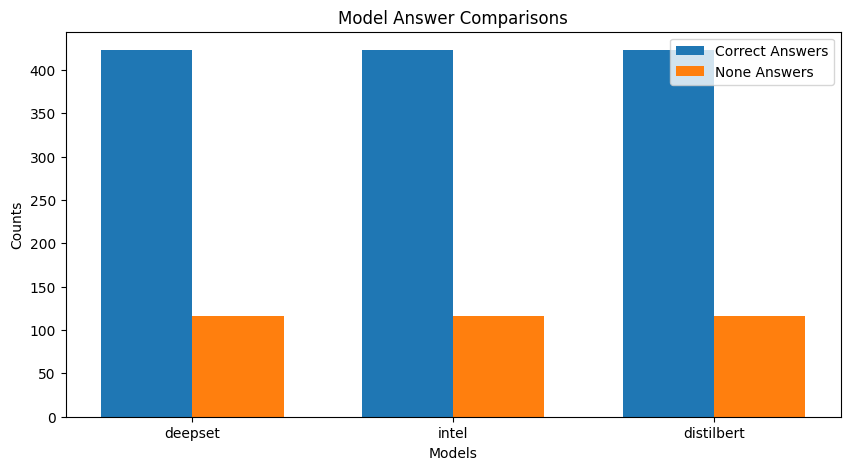

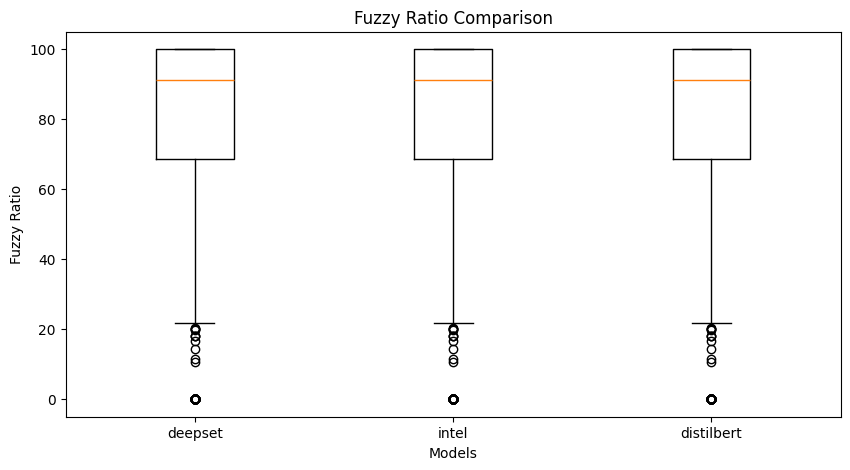

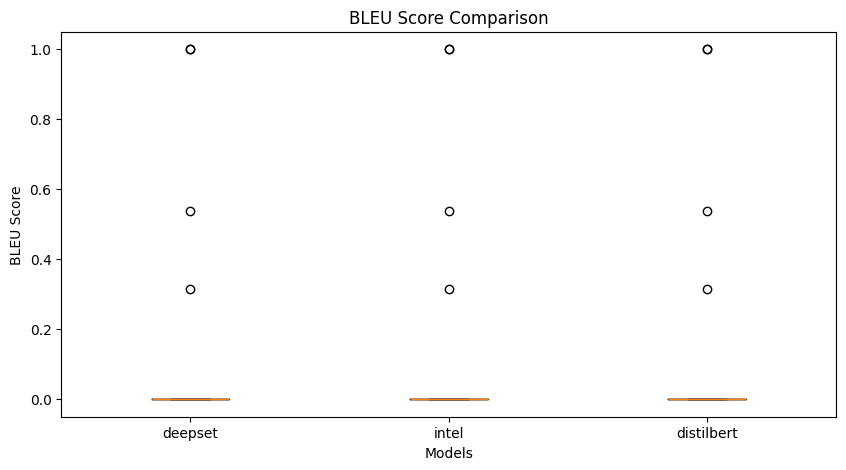

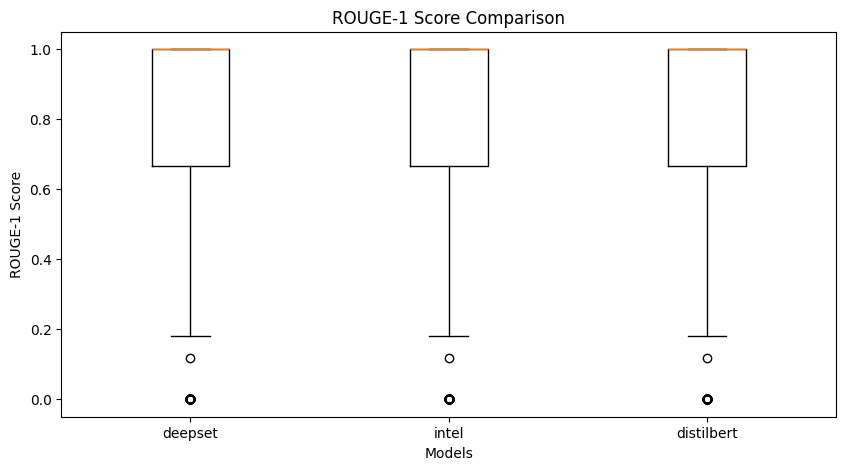

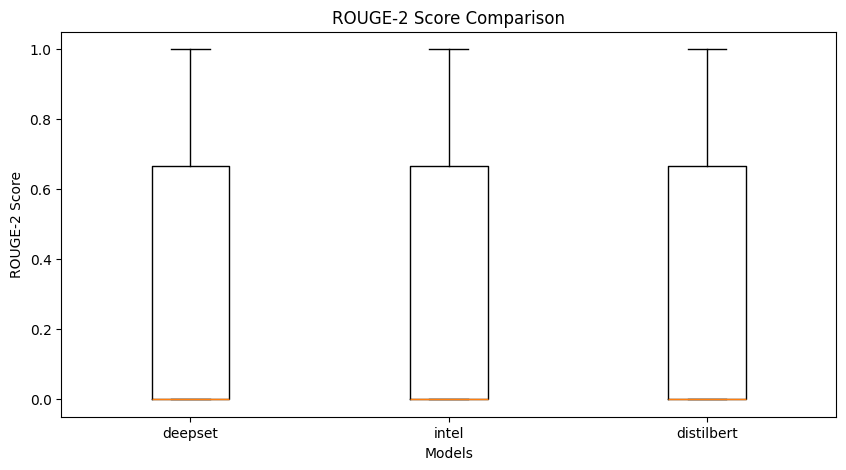

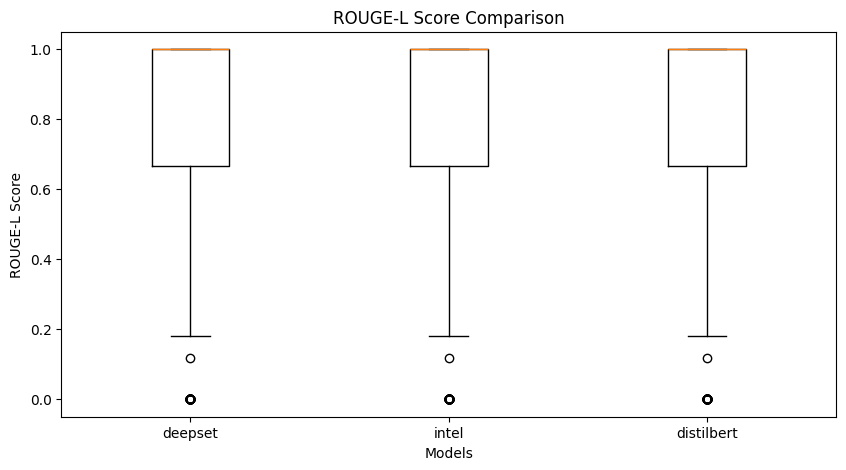

In [79]:
def plot_correctness(models_data):
    """
    Plot the correctness of the models.
    
    :param models_data: the models data
    """
    correct_counts = [df['is_correct'].sum() for df in models_data.values()]
    none_counts = [df['answer'].isnull().sum() for df in models_data.values()]
    
    x = range(len(models_data))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x, correct_counts, width, label='Correct Answers')
    rects2 = ax.bar([p + width for p in x], none_counts, width, label='None Answers')
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Counts')
    ax.set_title('Model Answer Comparisons')
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(models_data.keys())
    ax.legend()
    
    plt.show()

def plot_fuzzy(models_data):
    """
    Plot the fuzzy ratio of the models.
    
    :param models_data: the models data
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot([df['fuzzy'] for df in models_data.values()])
    ax.set_xticklabels(models_data.keys())
    ax.set_title('Fuzzy Ratio Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel('Fuzzy Ratio')
    plt.show()

def plot_bleu(models_data):
    """
    Plot the BLEU score of the models.
    
    :param models_data: the models data
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot([df['bleu'].dropna() for df in models_data.values()])
    ax.set_xticklabels(models_data.keys())
    ax.set_title('BLEU Score Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel('BLEU Score')
    plt.show()

def plot_rouge1(models_data):
    """
    Plot the ROUGE-1 score of the models.
    
    :param models_data: the models data
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot([df['rouge1'].dropna() for df in models_data.values()])
    ax.set_xticklabels(models_data.keys())
    ax.set_title('ROUGE-1 Score Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel('ROUGE-1 Score')
    plt.show()

def plot_rouge2(models_data):
    """
    Plot the ROUGE-2 score of the models.
    
    :param models_data: the models data
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot([df['rouge2'].dropna() for df in models_data.values()])
    ax.set_xticklabels(models_data.keys())
    ax.set_title('ROUGE-2 Score Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel('ROUGE-2 Score')
    plt.show()

def plot_rougeL(models_data):
    """
    Plot the ROUGE-L score of the models.
    
    :param models_data: the models data
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.boxplot([df['rougeL'].dropna() for df in models_data.values()])
    ax.set_xticklabels(models_data.keys())
    ax.set_title('ROUGE-L Score Comparison')
    ax.set_xlabel('Models')
    ax.set_ylabel('ROUGE-L Score')
    plt.show()
plot_correctness(models_data)
plot_fuzzy(models_data)
plot_bleu(models_data)
plot_rouge1(models_data)
plot_rouge2(models_data)
plot_rougeL(models_data)

## Statistical anaylsis
We follow the same approach as for the question generation models.

In [80]:
print('Shapiro-Wilk')
for metric in ['is_correct', 'fuzzy', 'bleu', 'rouge1', 'rouge2', 'rougeL']:
    for name, df in models_data.items():
        stat, p = shapiro(df[metric].dropna())
        print(f"{metric} - {name}: {stat}, {p}")
print('Median')
for metric in ['is_correct', 'fuzzy', 'bleu', 'rouge1', 'rouge2', 'rougeL']:
    for name, df in models_data.items():
        median = df[metric].median()
        print(f"{metric} - {name}: {median}")

print('Kruskal-Wallis')
for metric in ['is_correct', 'fuzzy', 'bleu', 'rouge1', 'rouge2', 'rougeL']:
    stat, p = kruskal(models_data['deepset'][metric].dropna(), models_data['intel'][metric].dropna(), models_data['distilbert'][metric].dropna())
    print(f"{metric} - {stat}, {p}")

print('Cliff\'s Delta')
for metric in ['is_correct', 'fuzzy', 'bleu', 'rouge1', 'rouge2', 'rougeL']:
    print(f"{metric}:")
    print(f"deepset vs intel: {cliffs_delta(models_data['deepset'][metric].dropna(), models_data['intel'][metric].dropna())}")
    print(f"deepset vs distilbert: {cliffs_delta(models_data['deepset'][metric].dropna(), models_data['distilbert'][metric].dropna())}")
    print(f"intel vs distilbert: {cliffs_delta(models_data['intel'][metric].dropna(), models_data['distilbert'][metric].dropna())}")

print('Number of correct answers')
print('Number of correct answers Deepset: ', models_data['deepset']['is_correct'].sum())
print('Number of correct answers Intel: ', models_data['intel']['is_correct'].sum())
print('Number of correct answer Distilbert: ', models_data['distilbert']['is_correct'].sum())

print('Number of none answers')
print('Number of none answers Deepset: ', models_data['deepset']['answer'].isnull().sum())
print('Number of none answers Intel: ', models_data['intel']['answer'].isnull().sum())
print('Number of none answers Distilbert: ', models_data['distilbert']['answer'].isnull().sum())

Shapiro-Wilk
is_correct - deepset: 0.6279108498044903, 6.226532519646512e-42
is_correct - intel: 0.6279108498044903, 6.226532519646512e-42
is_correct - distilbert: 0.6279108498044903, 6.226532519646512e-42
fuzzy - deepset: 0.7040521899157596, 1.1779978898694275e-38
fuzzy - intel: 0.7040521899157596, 1.1779978898694275e-38
fuzzy - distilbert: 0.7040521899157596, 1.1779978898694275e-38
bleu - deepset: 0.03574184024219729, 1.312454570798119e-54
bleu - intel: 0.03574184024219729, 1.312454570798119e-54
bleu - distilbert: 0.03574184024219729, 1.312454570798119e-54
rouge1 - deepset: 0.5948974646419868, 3.894812007873808e-41
rouge1 - intel: 0.5948974646419868, 3.894812007873808e-41
rouge1 - distilbert: 0.5948974646419868, 3.894812007873808e-41
rouge2 - deepset: 0.5841416302175154, 1.63043646274363e-41
rouge2 - intel: 0.5841416302175154, 1.63043646274363e-41
rouge2 - distilbert: 0.5841416302175154, 1.63043646274363e-41
rougeL - deepset: 0.5956458646555707, 4.140999871431241e-41
rougeL - intel: 

## See what resulted in None answer

In [81]:
test_data = load_test_data().to_pandas()
none_data = {
    'deepset': test_data[models_data['deepset']['answer'].isnull()],
    'intel': test_data[models_data['intel']['answer'].isnull()],
    'distilbert': test_data[models_data['distilbert']['answer'].isnull()]
}

for name, df in none_data.items():
    print(f"{name}: {df['support'].apply(lambda x: x == '').sum()}")
    

deepset: 116
intel: 116
distilbert: 116


## Investigate impact of length of support

In [82]:
test_data = datasets.load_dataset('allenai/sciq', split='test').to_pandas()
test_data['support_length'] = test_data['support'].apply(lambda x: len(x))
print('Shapiro-Wilk')
metrics = ['fuzzy', 'bleu', 'rouge1', 'rouge2', 'rougeL']
for metric in metrics:
    stat, p = shapiro(models_data['deepset'][metric].dropna())
    print(f"Support Length: {stat}, {p}")

print('Spearman')
for metric in metrics:
    non_none_test_data = test_data[models_data['deepset'][metric].notna()]
    non_none_data = models_data['deepset'][metric].dropna()
    stat, p = spearmanr(non_none_test_data['support_length'], non_none_data)
    print(f"Support Length vs {metric} Deepset: {stat}, {p}")

Shapiro-Wilk
Support Length: 0.7040521899157596, 1.1779978898694275e-38
Support Length: 0.03574184024219729, 1.312454570798119e-54
Support Length: 0.5948974646419868, 3.894812007873808e-41
Support Length: 0.5841416302175154, 1.63043646274363e-41
Support Length: 0.5956458646555707, 4.140999871431241e-41
Spearman
Support Length vs fuzzy Deepset: 0.3209228692956589, 2.1759415014407014e-25
Support Length vs bleu Deepset: -0.047601355586266776, 0.15733573270071
Support Length vs rouge1 Deepset: -0.0739886669942211, 0.027825049456241563
Support Length vs rouge2 Deepset: -0.021957254677303507, 0.5144069854157728
Support Length vs rougeL Deepset: -0.07419289833686935, 0.02739569994738125


# Distractor Generation Model Comparison

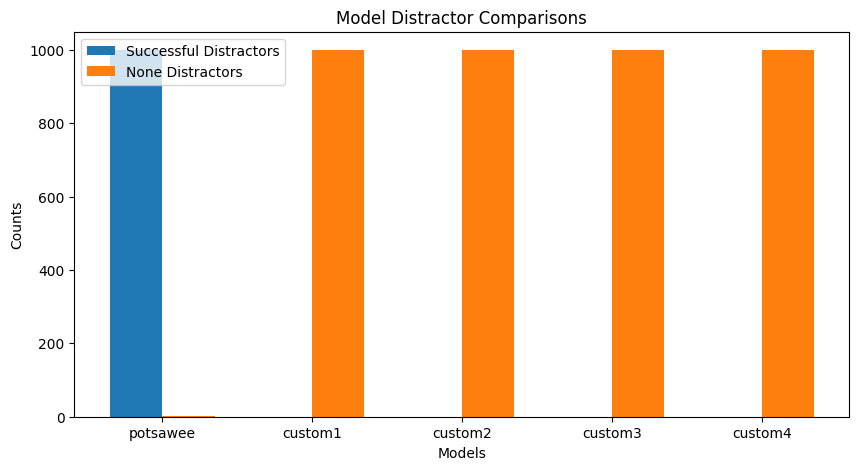

In [83]:
def load_distractor_model_data_from_file(model_name):
    """
    Load the distractor model data from the file.
    
    :param model_name: the name of the model
    """
    filename = f"./distractor_models_results/generated_distractors_{model_name}.json"
    with open(filename, 'r', encoding='utf-8') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

distractors_data = {
    'potsawee': None,
    'custom1': None,
    'custom2': None,
    'custom3': None,
    'custom4': None
}

for name in distractors_data.keys():
    df = load_distractor_model_data_from_file(name)
    distractors_data[name] = df
    
def plot_successful_distractors(distractors_data):
    """
    Plot the successful distractors of the models.
    
    :param distractors_data: the distractors data
    """
    total_len = [len(df) for df in distractors_data.values()]
    none_counts = np.array([df['bleurt_score'].isnull().sum() for df in distractors_data.values()])
    non_none_counts = total_len - none_counts
    
    x = range(len(distractors_data))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x, non_none_counts, width, label='Successful Distractors')
    rects2 = ax.bar([p + width for p in x], none_counts, width, label='None Distractors')
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Counts')
    ax.set_title('Model Distractor Comparisons')
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels(distractors_data.keys())
    ax.legend()
    
    plt.show()
plot_successful_distractors(distractors_data)
    

## Statistical analysis

In [84]:
print('Shapiro-Wilk')
for name, df in distractors_data.items():
    computed_metrics = df['bleurt_score'].dropna()
    if len(computed_metrics) < 3:
        print(f"Skipping {name} as there are not enough samples")
        continue
    stat, p = shapiro(computed_metrics)
    print(f"Bleurt - {name}: {stat}, {p}")

Shapiro-Wilk
Bleurt - potsawee: 0.9904803634617735, 4.575240170509725e-06
Skipping custom1 as there are not enough samples
Skipping custom2 as there are not enough samples
Skipping custom3 as there are not enough samples
Skipping custom4 as there are not enough samples


## Investigate impact of length of support

In [85]:
test_data = datasets.load_dataset('allenai/sciq', split='test').to_pandas()
test_data['support_length'] = test_data['support'].apply(lambda x: len(x))

print('Shapiro-Wilk')
stat, p = shapiro(distractors_data['potsawee']['bleurt_score'].dropna())
print(f"Bleurt - Potsawee: {stat}, {p}")

print('Spearman')
test_data.drop(605, inplace=True)
stat, p = spearmanr(test_data['support_length'], distractors_data['potsawee']['bleurt_score'].dropna())
print(f"Support Length vs BLEURT Potsawee: {stat}, {p}")

Shapiro-Wilk
Bleurt - Potsawee: 0.9904803634617735, 4.575240170509725e-06
Spearman
Support Length vs BLEURT Potsawee: -0.007141992661768069, 0.8216238163212392


In [86]:
print('Mean support length: ', test_data['support_length'].mean())
print('Median support length: ', test_data['support_length'].median())
print('Max support length: ', test_data['support_length'].max())
print('Min support length: ', test_data['support_length'].min())

Mean support length:  422.6936936936937
Median support length:  297.0
Max support length:  2940
Min support length:  0
